# Community Detection in FriendFeed Network

This notebook focuses on detecting communities within the FriendFeed social network. We'll use the preprocessed datasets to build a graph and analyze community structures.

In [1]:
import os
import gc
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from collections import Counter
from concurrent.futures import ProcessPoolExecutor, as_completed
from joblib import Parallel, delayed

## load the network from files

%%time
full_graph = nx.Graph()
path_to_graph_batches = "graph/"
for file in os.listdir(path_to_graph_batches):
    if file.endswith(".graphml"):
        subgraph = nx.read_graphml(os.path.join(path_to_graph_batches, file))
        full_graph.add_edges_from(subgraph.edges(data=True))  # Add edges with attributes
        print(f'* {file} loaded!')

print(f"Unified graph has {full_graph.number_of_nodes()} nodes and {full_graph.number_of_edges()} edges")

In [2]:
%%time
num_cpus = 3
def load_graph(file_path):
    """Function to load a single GraphML file and return the corresponding graph."""
    subgraph = nx.read_graphml(file_path)
    return subgraph

# Path to where the graph batches are stored
path_to_graph_batches = "graph/"
graph_files = [os.path.join(path_to_graph_batches, file) for file in os.listdir(path_to_graph_batches) if file.endswith(".graphml")]

# Initialize an empty graph to combine everything
full_graph = nx.Graph()

with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    # Submit all graph loading tasks to the executor
    futures = {executor.submit(load_graph, file): file for file in graph_files}
    
    # Collect the results as they complete
    for future in as_completed(futures):
        file = futures[future]
        try:
            subgraph = future.result()
            full_graph.add_edges_from(subgraph.edges(data=True))  # Add edges with attributes
            print(f'* {file} loaded!')
            gc.collect()
        except Exception as e:
            print(f'Error loading {file}: {e}')
            gc.collect()

# Now full_graph contains the unified network
print(f"Unified graph has {full_graph.number_of_nodes()} nodes and {full_graph.number_of_edges()} edges")

* graph/graph_batch_4.graphml loaded!
* graph/graph_batch_2.graphml loaded!
* graph/graph_batch_6.graphml loaded!
* graph/graph_batch_5.graphml loaded!
* graph/graph_batch_0.graphml loaded!
* graph/graph_batch_7.graphml loaded!
* graph/graph_batch_3.graphml loaded!
* graph/graph_batch_9.graphml loaded!
* graph/graph_batch_8.graphml loaded!
* graph/graph_batch_1.graphml loaded!
Unified graph has 643416 nodes and 22269002 edges
CPU times: user 3min 18s, sys: 16.1 s, total: 3min 34s
Wall time: 5min 44s


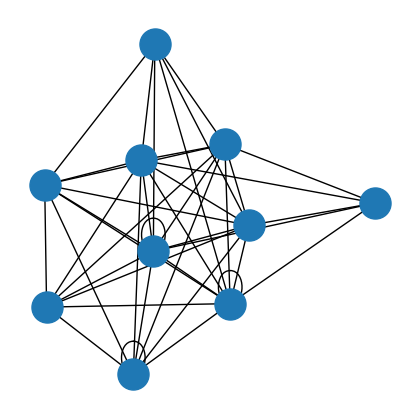

In [3]:
num_nodes_to_sample = 10  # Set your desired number of nodes
node_degrees = dict(full_graph.degree())
sampled_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:num_nodes_to_sample]
G_sampled = full_graph.subgraph(sampled_nodes).copy()
plt.figure(figsize=(4, 4))  # Set the plot size
nx.draw(G_sampled, node_size=500)
plt.show()

In [4]:
# Print node information plotted above!
num_nodes_to_sample = 10
sorted_nodes_with_degrees = sorted(node_degrees.items(), key=lambda item: item[1], reverse=True)[:num_nodes_to_sample]

for node, degree in sorted_nodes_with_degrees:
    print(f"Node: {node}, Degree: {degree}")

Node: br3adman, Degree: 104669
Node: malikimrana1, Degree: 97931
Node: phasuk111, Degree: 93031
Node: sonergonul, Degree: 92079
Node: omarabid, Degree: 84426
Node: xahac, Degree: 77391
Node: nickcodipietro, Degree: 70056
Node: alpb, Degree: 64969
Node: kmorrison, Degree: 60065
Node: kimkardashian, Degree: 59052


In [5]:
# Get the degree of each node (the number of edges connected to each node)
degree_counts = dict(full_graph.degree())

# Prepare a list of degree values
degree_values = list(degree_counts.values())

# Count the frequency of each degree value
degree_distribution = Counter(degree_values)

# Display the number of nodes for each degree (0 edges, 1 edge, 2 edges, etc.)
# for degree, count in sorted(degree_distribution.items()):
    # print(f"Nodes with {degree} edges: {count}")

# Calculate min, max, average, and median of the degree values
min_degree = np.min(degree_values)
max_degree = np.max(degree_values)
average_degree = np.mean(degree_values)
median_degree = np.median(degree_values)

# Count the number of nodes with min and max edges
min_degree_count = degree_distribution[min_degree]
max_degree_count = degree_distribution[max_degree]

# Print statistics
print(f"\nMinimum degree: {min_degree} (Nodes: {min_degree_count})")
print(f"Maximum degree: {max_degree} (Nodes: {max_degree_count})")
print(f"Average degree: {average_degree:.2f}")
print(f"Median degree: {median_degree}")


Minimum degree: 1 (Nodes: 147619)
Maximum degree: 104669 (Nodes: 1)
Average degree: 69.22
Median degree: 6.0


## RUN louvain in parallel

In [8]:
%%time
def run_louvain_on_subgraph(subgraph):
    return community_louvain.best_partition(subgraph)

# Step 1: Create subgraphs for parallel processing
# For demonstration, we will use connected components as subgraphs
subgraphs = list(nx.connected_components(full_graph))
subgraph_list = [full_graph.subgraph(component).copy() for component in subgraphs]
print(len(subgraph_list))
gc.collect()

1027
CPU times: user 3min 9s, sys: 6.65 s, total: 3min 15s
Wall time: 3min 21s


0

In [ ]:
# Step 2: Run the Louvain method in parallel
num_cpus = 4  # Define the number of CPUs you want to use
partitions = Parallel(n_jobs=num_cpus)(delayed(run_louvain_on_subgraph)(subgraph) for subgraph in subgraph_list)

In [ ]:
# Step 3: Combine the results
combined_partition = {}
for partition in partitions:
    combined_partition.update(partition)
print(f"Number of communities detected: {len(set(combined_partition.values()))}")

In [ ]:
# Step 4: Print the sizes of each community
community_sizes = {k: list(combined_partition.values()).count(k) for k in set(combined_partition.values())}
for community, size in community_sizes.items():
    print(f"Community {community}: {size} nodes")

In [ ]:
# Step 5: Create a visualization
values = [combined_partition[node] for node in full_graph.nodes()]
plt.figure(figsize=(12, 8))
nx.draw(full_graph, node_color=values, with_labels=False, node_size=10, cmap=plt.cm.Rainbow)
plt.title("Louvain Clustering of the Graph (Parallelized)")
plt.show()

In [ ]:
# Another visualization
pos = nx.spring_layout(full_graph)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(full_graph, pos, partition.keys(), node_size=100,cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(full_graph, pos, alpha=0.5)
plt.show()

In [ ]:
print(input('Wait here ....'))

## 3. Analyze Network Structure

Let's examine the basic characteristics of the network, such as degree distributions.

In [ ]:
# Calculate degree distributions
degrees = dict(full_graph.degree())
# in_degrees = dict(full_graph.in_degree())
# out_degrees = dict(full_graph.out_degree())

# Plot degree distribution
plt.figure(figsize=(10, 6))
sns.histplot(list(degrees.values()), bins=30, kde=True)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

## 4. Detect Communities Using the Louvain Method

The Louvain algorithm is a popular method for community detection in large networks. We'll use this method to detect communities and analyze them.

In [ ]:
%%time
# Convert graph to undirected for community detection
G_undirected = G.to_undirected()

# Apply Louvain method for community detection
partition = community_louvain.best_partition(G_undirected)
communities = set(partition.values())
num_communities = len(communities)

print(f"Number of communities detected: {num_communities}")

# Add community information as node attribute
nx.set_node_attributes(G, partition, 'community')

## 5. Visualize Communities

Let's visualize the detected communities. Each node will be colored based on the community it belongs to.

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_undirected, k=0.1)

# Draw nodes with colors according to community
colors = [partition[node] for node in G_undirected.nodes]
nx.draw_networkx_nodes(G_undirected, pos, node_color=colors, cmap=plt.cm.jet, node_size=20)

# Draw edges
nx.draw_networkx_edges(G_undirected, pos, alpha=0.1)

plt.title('Community Detection using Louvain Method')
plt.axis('off')
plt.show()

## 6. Community Analysis

We can further analyze the communities to understand their sizes and characteristics.

In [ ]:
# Calculate size of each community
community_sizes = pd.Series(list(partition.values())).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=community_sizes.index, y=community_sizes.values, palette='viridis')
plt.title('Community Size Distribution')
plt.xlabel('Community ID')
plt.ylabel('Number of Nodes')
plt.show()

## 7. Save the Results

Finally, let's save the graph with community information for further analysis if needed.

In [ ]:
# Save graph with community info
nx.write_gexf(G, 'friendfeed_community_graph.gexf')
print("Graph with community information saved as 'friendfeed_community_graph.gexf'.")